# STEP 0

## 0.1. Imports


In [7]:
import numpy                        as np
import pandas                       as pd
import seaborn                      as sns
import matplotlib.pyplot            as plt
from xgboost                        import XGBRegressor
from prophet                        import Prophet
from pmdarima                       import auto_arima
from matplotlib.ticker              import ScalarFormatter
from tensorflow.keras.models        import Sequential
from tensorflow.keras.layers        import LSTM, Dense
from sklearn.preprocessing          import MinMaxScaler
from sklearn.metrics                import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.stattools      import adfuller
from statsmodels.tsa.seasonal       import seasonal_decompose
from statsmodels.tsa.arima.model    import ARIMA


## 0.2. Funções de apoio

In [8]:
# ===================================================================
# Configura o notebook
def jupyter_settings():
    import warnings
    warnings.filterwarnings('ignore')
    %matplotlib inline

    # Tamanho e estilo dos gráficos
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [22, 9]
    plt.rcParams['font.size'] = 21

    # Configuração de exibição das linhas e colunas do pandas
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    # configuração do pandas para quantidade de casas decimais
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()

jupyter_settings()



def plota_ausentes(data, title, x_title):
    """
    Plota uma tabela com a contagem de valores ausentes por coluna e um gráfico de
    barras com o percentual de ausentes por colunas caso existam dados ausentes,
    caso não, imprime o resultado de isna().sum()
    Params
    data: dataframe com os dados a serem plotados
    title: título do gráfico
    title: título do eixo x
    """

    # Pega as colunas com dados ausentes
    colunas_com_nan = [col for col in data.columns if data[col].isna().sum() > 0]

    # Plot do gráfico de barras com o percentual
    if len(colunas_com_nan) > 0:    # Se tiver colunas com dados faltantes
        ax = (  # Grafico                              
            data[colunas_com_nan]   # Dataframe a ser plotado no gráfico
            .isna() # Pegar valores faltantes
            .mean() # Pegar a média dos valores faltantes
            .sort_values(ascending=True)    # Ordenar os dados 
            .mul(100)   # multiplicar a média por 100 (percentual)
            .round(1)   # Arredondar as casas decimais para 1
            .plot(kind="barh")  # Tipo do gráfico (barras horizontais)
        )
        _ = ax.set_xlabel(x_title)  # Título do eixo x
        _ = ax.set_title(title) # Título do gráfico
        _ = ax.bar_label(ax.containers[0])  # Mostrar valores sobre as barras

        # Tabela da contagems dos dados faltantes
        print("Contagem de faltantes")
        print(data[colunas_com_nan].isna().sum().sort_values(ascending=True))
    else:   # Caso não exista dados faltantes imprime uma lista das colunas
        print('Contagem de faltantes')
        print(data.isna().sum())

## 0.3. Carregando os dados

In [9]:
# Leitura dos dados principais
df_raw = pd.read_csv('../data/df_case_1_-_500_linhas.csv')

# 1 - Entendimento dos dados


## 1.1. Amostra do dataset

In [10]:
df_xgb = df_raw.copy()
df_xgb.head()

,CATEGORIA,PRODUTO,FORNECEDOR,COMPRADOR,CENTROS DE DISTRIBUICAO,DESCRICAO,QTD DE CAIXAS,MAR22,ABR22,MAI22,JUN22,JUL22,AGO22,SET22,OUT22,NOV22,DEZ22,JAN23,FEV23,MAR23,ABR23,MAI23,JUN23,JUL23,AGO23,SET23,OUT23,NOV23,DEZ23,JAN24,FEV24,MAR24
0,A,A,A,A,A,A,109,356,374,408,453,413,323,276,296,512,554,658,352,484,513,369,404,350,466,290,476,524,273,199,313,197
1,A,A,A,A,B,B,70,994,723,1310,1214,1105,1530,1445,1721,1284,1607,1483,1497,2006,1285,1529,1897,1840,2427,1655,1669,1970,1700,1895,1385,2243
2,B,B,B,B,C,C,123,74,65,71,63,59,132,148,163,80,171,5,1,80,167,120,144,57,69,165,129,153,149,145,125,132
3,B,C,C,C,D,D,196,520,466,603,320,700,700,554,475,516,529,508,417,455,327,362,496,568,443,304,408,372,315,447,610,776
4,A,D,A,A,E,E,99,37,1,78,74,9,75,7,64,35,28,80,64,37,85,3,75,60,85,13,45,24,8,64,79,96


## 1.2. Volumetria dos dados

In [11]:
# Conferindo a volumetria
print(f"Quantidade de colunas:  {df_xgb.shape[1]}")
print(f"Quantidade de linhas:   {df_xgb.shape[0]}")

Quantidade de colunas:  32
Quantidade de linhas:   500


## 1.3. Tipos dos dados

In [12]:
df_xgb.dtypes

CATEGORIA                  object
PRODUTO                    object
FORNECEDOR                 object
COMPRADOR                  object
CENTROS DE DISTRIBUICAO    object
DESCRICAO                  object
QTD DE CAIXAS               int64
MAR22                       int64
ABR22                       int64
MAI22                       int64
JUN22                       int64
JUL22                       int64
AGO22                       int64
SET22                       int64
OUT22                       int64
NOV22                       int64
DEZ22                       int64
JAN23                       int64
FEV23                       int64
MAR23                       int64
ABR23                       int64
MAI23                       int64
JUN23                       int64
JUL23                       int64
AGO23                       int64
SET23                       int64
OUT23                       int64
NOV23                       int64
DEZ23                       int64
JAN24         

## 1.4.  Verificando dados faltantes

In [13]:
plota_ausentes(df_xgb, '% de faltantes', 'Percentual')

Contagem de faltantes
CATEGORIA                  0
PRODUTO                    0
FORNECEDOR                 0
COMPRADOR                  0
CENTROS DE DISTRIBUICAO    0
DESCRICAO                  0
QTD DE CAIXAS              0
MAR22                      0
ABR22                      0
MAI22                      0
JUN22                      0
JUL22                      0
AGO22                      0
SET22                      0
OUT22                      0
NOV22                      0
DEZ22                      0
JAN23                      0
FEV23                      0
MAR23                      0
ABR23                      0
MAI23                      0
JUN23                      0
JUL23                      0
AGO23                      0
SET23                      0
OUT23                      0
NOV23                      0
DEZ23                      0
JAN24                      0
FEV24                      0
MAR24                      0
dtype: int64


## 1.5.  Verificando dados duplicados

In [14]:
df_xgb.duplicated().sum()

0

## 1.6.  Verificação complementar

In [15]:
df_xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   CATEGORIA                500 non-null    object
 1   PRODUTO                  500 non-null    object
 2   FORNECEDOR               500 non-null    object
 3   COMPRADOR                500 non-null    object
 4   CENTROS DE DISTRIBUICAO  500 non-null    object
 5   DESCRICAO                500 non-null    object
 6   QTD DE CAIXAS            500 non-null    int64 
 7   MAR22                    500 non-null    int64 
 8   ABR22                    500 non-null    int64 
 9   MAI22                    500 non-null    int64 
 10  JUN22                    500 non-null    int64 
 11  JUL22                    500 non-null    int64 
 12  AGO22                    500 non-null    int64 
 13  SET22                    500 non-null    int64 
 14  OUT22                    500 non-null    i

# 2 - Análise exploratória dos dados

## 2.1. Insighths com máximos e mínimos (Preparação)

In [16]:
# Cria um lista com as colunas de meses
colunas_meses = df_xgb.columns[df_xgb.columns.get_loc("MAR22"):]
df_xgb['TOTAL_VENDAS'] = df_xgb[colunas_meses].sum(axis=1)


# Top 5 maiores por grupo (Vendas)
df_produtos_top5 = df_xgb.groupby('PRODUTO')['TOTAL_VENDAS'].sum().nlargest(5).reset_index()
df_categoria_top5 = df_xgb.groupby('CATEGORIA')['TOTAL_VENDAS'].sum().nlargest(5).reset_index()
df_fornecedor_top5 = df_xgb.groupby('FORNECEDOR')['TOTAL_VENDAS'].sum().nlargest(5).reset_index()
df_centro_top5 = df_xgb.groupby('CENTROS DE DISTRIBUICAO')['TOTAL_VENDAS'].sum().nlargest(5).reset_index()

# Top 5 menores por grupo (Vendas)
df_produtos_bottom5 = df_xgb.groupby('PRODUTO')['TOTAL_VENDAS'].sum().nsmallest(5).reset_index()
df_categoria_bottom5 = df_xgb.groupby('CATEGORIA')['TOTAL_VENDAS'].sum().nsmallest(5).reset_index()
df_fornecedor_bottom5 = df_xgb.groupby('FORNECEDOR')['TOTAL_VENDAS'].sum().nsmallest(5).reset_index()
df_centro_bottom5 = df_xgb.groupby('CENTROS DE DISTRIBUICAO')['TOTAL_VENDAS'].sum().nsmallest(5).reset_index()

# Top 5 maiores por grupo (Estoque)
df_produtos_estoque_top5 = df_xgb.groupby('PRODUTO')['QTD DE CAIXAS'].sum().nlargest(5).reset_index()
df_categoria_estoque_top5 = df_xgb.groupby('CATEGORIA')['QTD DE CAIXAS'].sum().nlargest(5).reset_index()
df_fornecedor_estoque_top5 = df_xgb.groupby('FORNECEDOR')['QTD DE CAIXAS'].sum().nlargest(5).reset_index()
df_centro_estoque_top5 = df_xgb.groupby('CENTROS DE DISTRIBUICAO')['QTD DE CAIXAS'].sum().nlargest(5).reset_index()

# Top 5 menores por grupo (Estoque)
df_produtos_estoque_bottom5 = df_xgb.groupby('PRODUTO')['QTD DE CAIXAS'].sum().nsmallest(5).reset_index()
df_categoria_estoque_bottom5 = df_xgb.groupby('CATEGORIA')['QTD DE CAIXAS'].sum().nsmallest(5).reset_index()
df_fornecedor_estoque_bottom5 = df_xgb.groupby('FORNECEDOR')['QTD DE CAIXAS'].sum().nsmallest(5).reset_index()
df_centro_estoque_bottom5 = df_xgb.groupby('CENTROS DE DISTRIBUICAO')['QTD DE CAIXAS'].sum().nsmallest(5).reset_index()

# Função para plotar gráficos de barras formatados
def plotar_barra(df, x_col, y_col, title, xlabel, ylabel):
	"""
	Plota um gráfico de barras formatado com os dados fornecidos.
	
	Params:
	df: DataFrame com os dados a serem plotados
	x_col: coluna do DataFrame para o eixo x
	y_col: coluna do DataFrame para o eixo y
	title: título do gráfico
	xlabel: título do eixo x
	ylabel: título do eixo y
	"""
	plt.bar(df[x_col], df[y_col])
	plt.title(title)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	
	# Desativa notação científica no eixo Y
	plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
	plt.ticklabel_format(style='plain', axis='y')  
	
	plt.grid(True, axis='y', linestyle='--', alpha=0.5)
	plt.tight_layout()

## 2.2. Top 5 - Mais vendidos (Produtos, Categorias, Fornecedores e Centros de Distribuição)

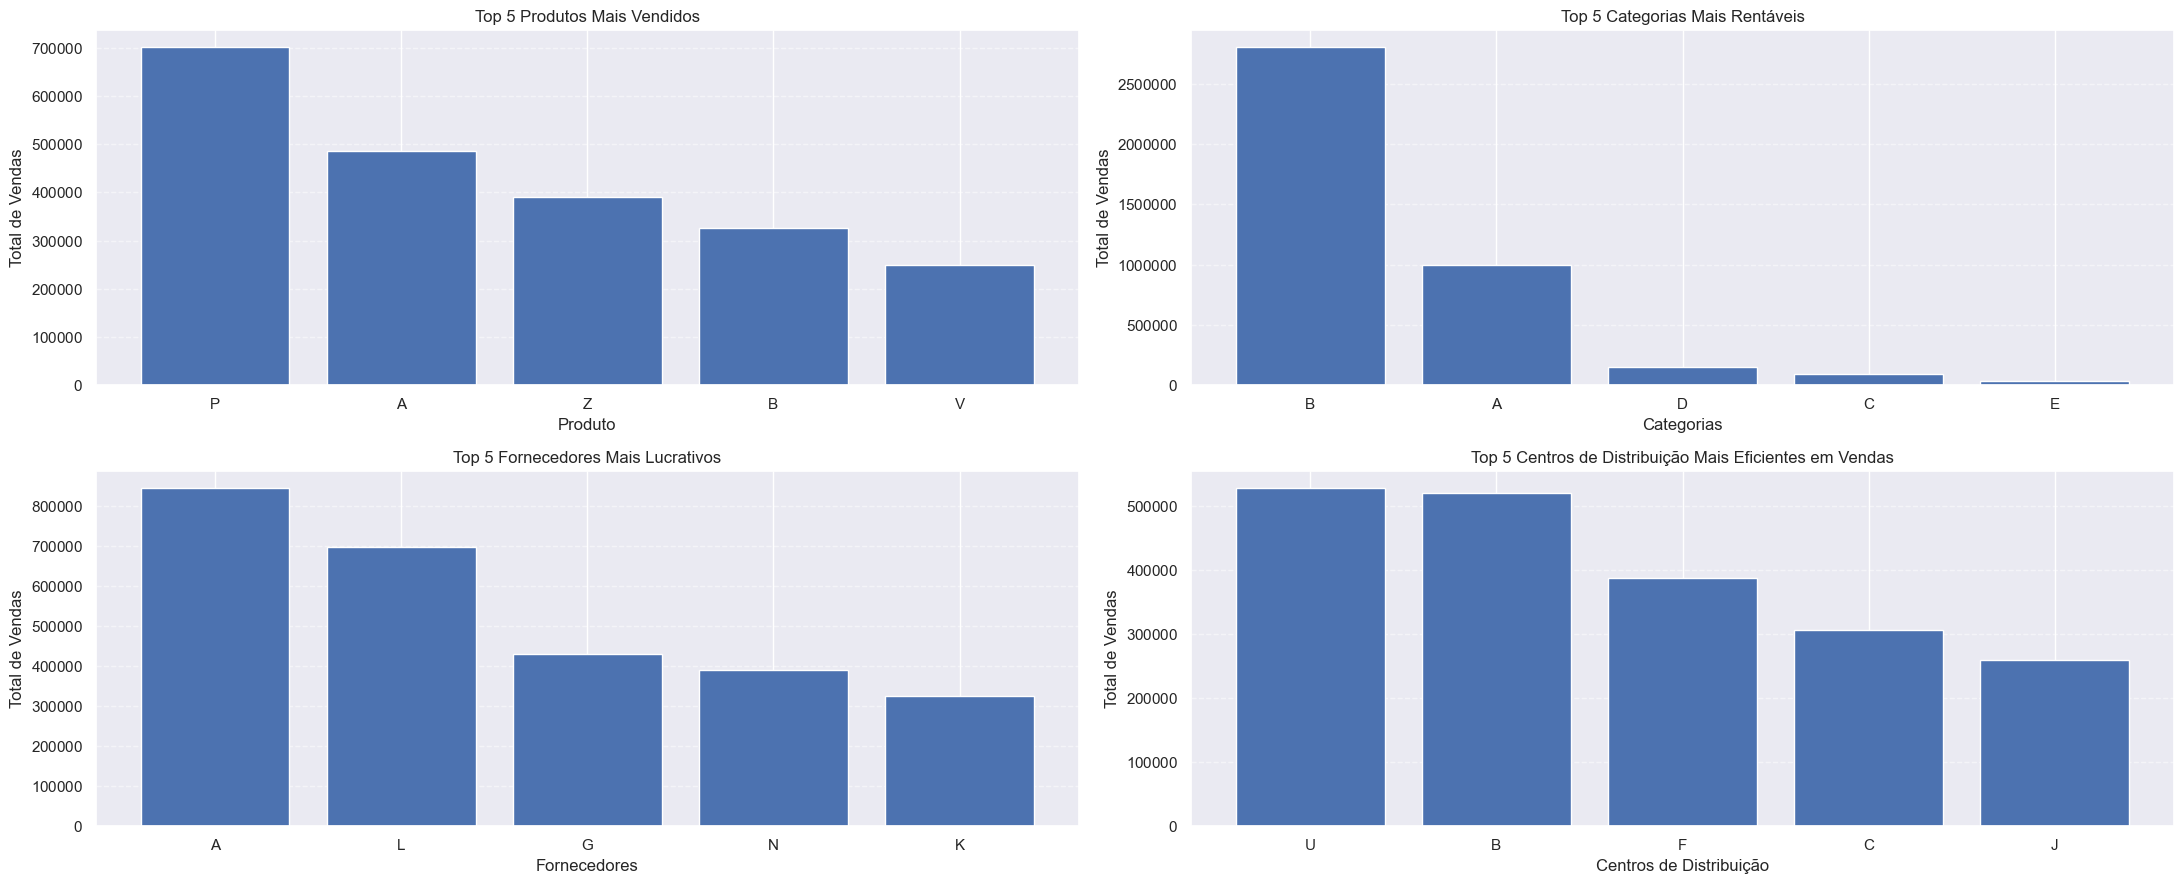

In [17]:
# Gráficos
plt.subplot(2, 2, 1)
plotar_barra(df_produtos_top5, 'PRODUTO', 'TOTAL_VENDAS', 'Top 5 Produtos Mais Vendidos', 'Produto', 'Total de Vendas')
plt.subplot(2, 2, 2)
plotar_barra(df_categoria_top5, 'CATEGORIA', 'TOTAL_VENDAS', 'Top 5 Categorias Mais Rentáveis', 'Categorias', 'Total de Vendas')
plt.subplot(2, 2, 3)
plotar_barra(df_fornecedor_top5, 'FORNECEDOR', 'TOTAL_VENDAS', 'Top 5 Fornecedores Mais Lucrativos', 'Fornecedores', 'Total de Vendas')
plt.subplot(2, 2, 4)
plotar_barra(df_centro_top5, 'CENTROS DE DISTRIBUICAO', 'TOTAL_VENDAS', 'Top 5 Centros de Distribuição Mais Eficientes em Vendas', 'Centros de Distribuição', 'Total de Vendas')

## 2.3. Top 5 - Menos vendidos (Produtos, Categorias, Fornecedores e Centros de Distribuição)

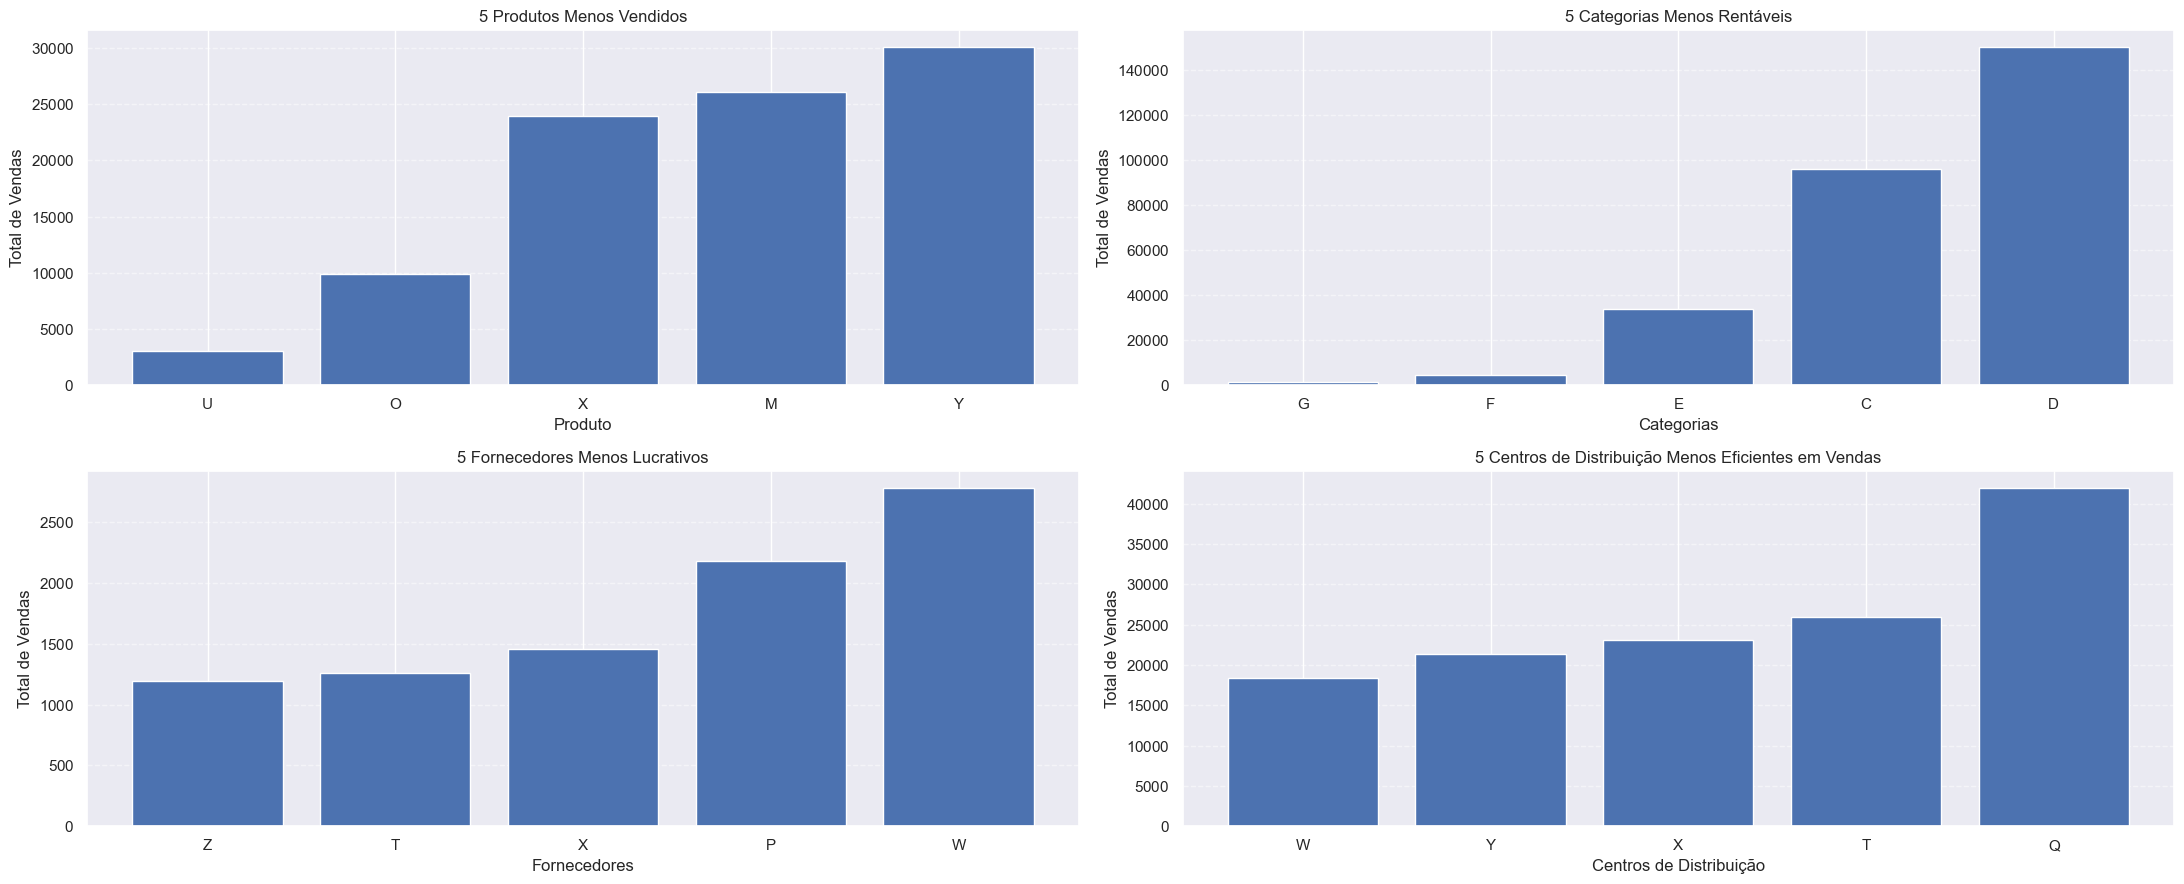

In [18]:
# Gráficos
plt.subplot(2, 2, 1)
plotar_barra(df_produtos_bottom5, 'PRODUTO', 'TOTAL_VENDAS', '5 Produtos Menos Vendidos', 'Produto', 'Total de Vendas')
plt.subplot(2, 2, 2)
plotar_barra(df_categoria_bottom5, 'CATEGORIA', 'TOTAL_VENDAS', '5 Categorias Menos Rentáveis', 'Categorias', 'Total de Vendas')
plt.subplot(2, 2, 3)
plotar_barra(df_fornecedor_bottom5, 'FORNECEDOR', 'TOTAL_VENDAS', '5 Fornecedores Menos Lucrativos', 'Fornecedores', 'Total de Vendas')
plt.subplot(2, 2, 4)
plotar_barra(df_centro_bottom5, 'CENTROS DE DISTRIBUICAO', 'TOTAL_VENDAS', '5 Centros de Distribuição Menos Eficientes em Vendas', 'Centros de Distribuição', 'Total de Vendas')

## 2.4. Top 5 - Maiores e menores estoques (Produtos e Centros de Distribuição)

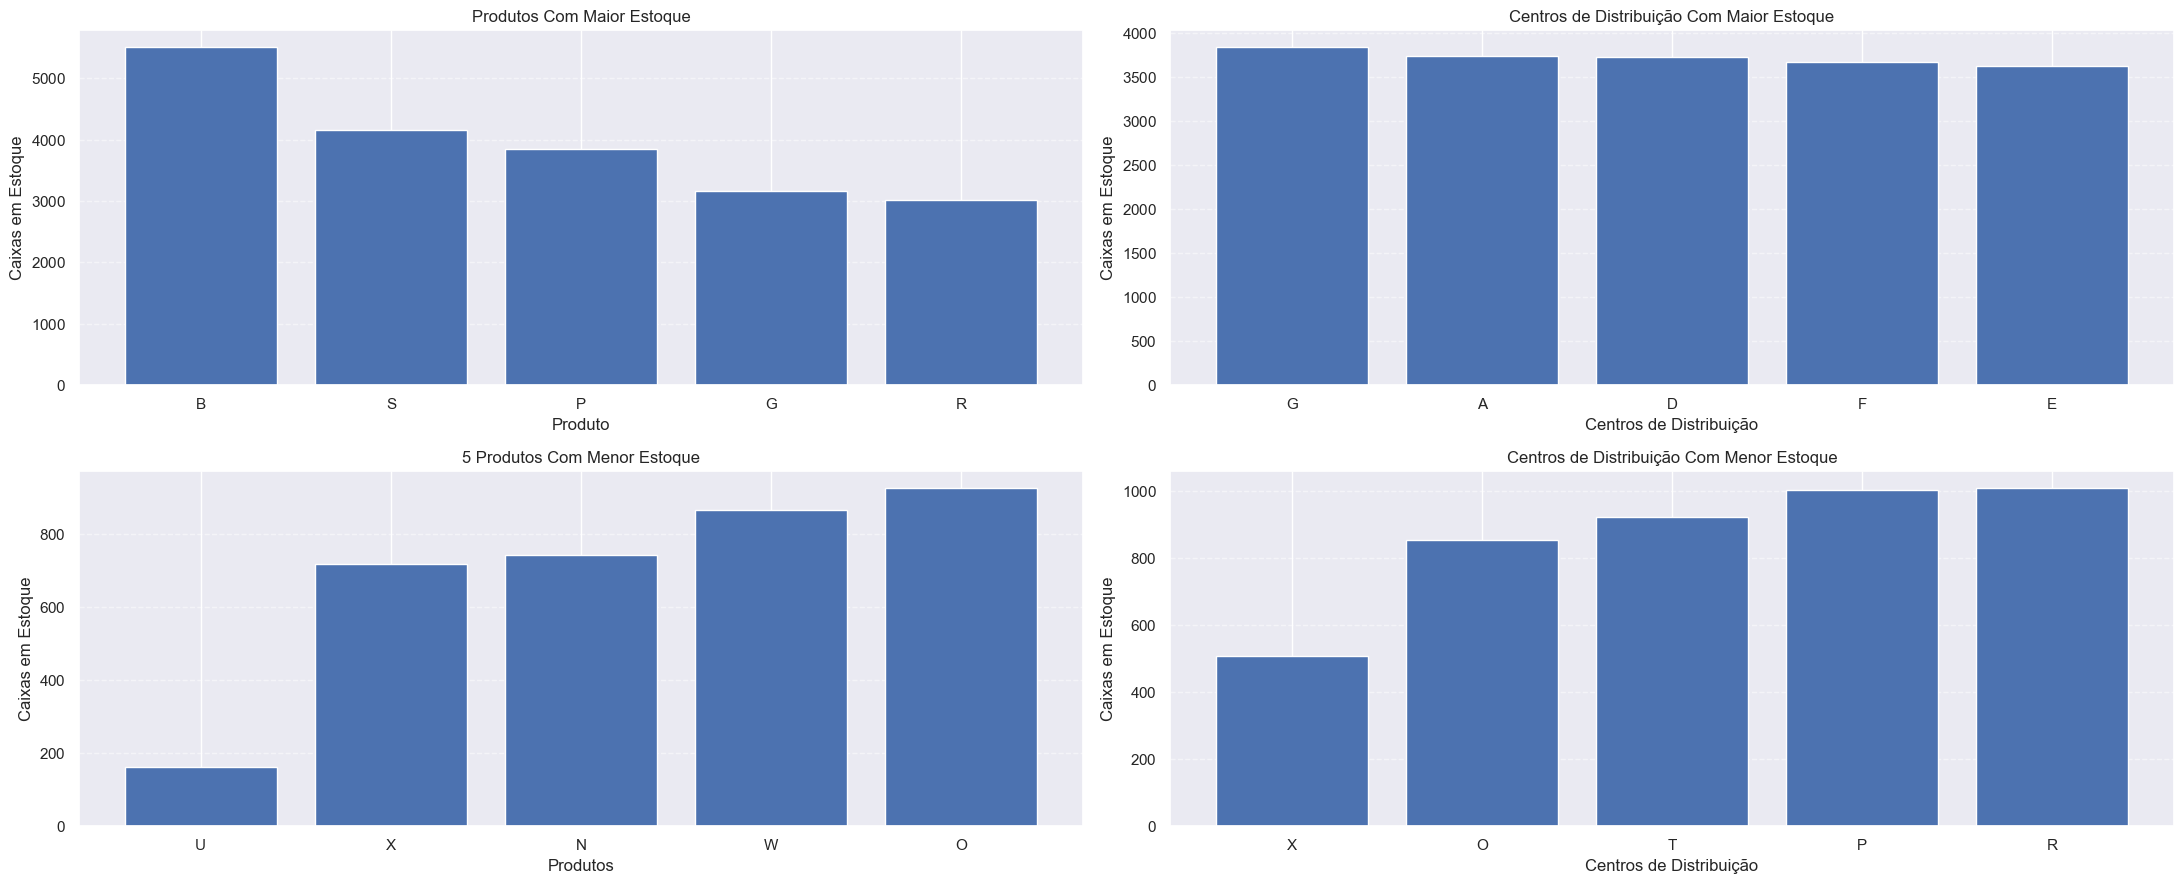

In [19]:
# Gráficos
plt.subplot(2, 2, 1)
plotar_barra(df_produtos_estoque_top5, 'PRODUTO', 'QTD DE CAIXAS', 'Produtos Com Maior Estoque', 'Produto', 'Caixas em Estoque')
plt.subplot(2, 2, 2)
plotar_barra(df_centro_estoque_top5, 'CENTROS DE DISTRIBUICAO', 'QTD DE CAIXAS', 'Centros de Distribuição Com Maior Estoque', 'Centros de Distribuição', 'Caixas em Estoque')
plt.subplot(2, 2, 3)
plotar_barra(df_produtos_estoque_bottom5, 'PRODUTO', 'QTD DE CAIXAS', '5 Produtos Com Menor Estoque', 'Produtos', 'Caixas em Estoque')
plt.subplot(2, 2, 4)
plotar_barra(df_centro_estoque_bottom5, 'CENTROS DE DISTRIBUICAO', 'QTD DE CAIXAS', 'Centros de Distribuição Com Menor Estoque', 'Centros de Distribuição', 'Caixas em Estoque')

## 2.5. Top 5 - Produtos Críticos (Produtos com alta venda e baixo estoque)

,PRODUTO,TOTAL_VENDAS,QTD DE CAIXAS
15,P,701039,28
0,A,486437,25
25,Z,390847,131
1,B,325346,58
21,V,250378,22


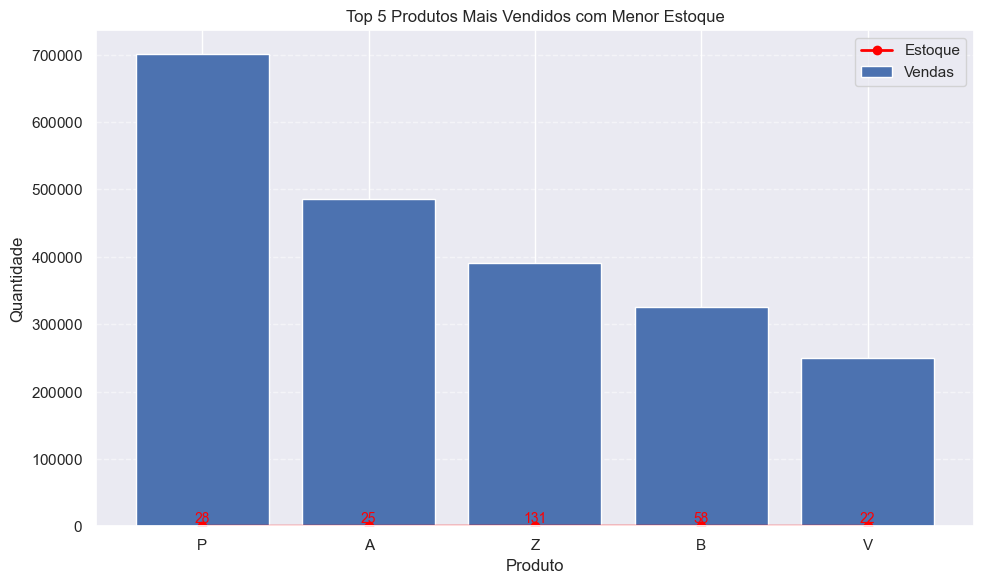

In [20]:
# Agrupa TOTAL_VENDAS e pega o menor estoque para cada produto
df_produtos = df_xgb.groupby('PRODUTO').agg({
    'TOTAL_VENDAS': 'sum',
    'QTD DE CAIXAS': 'min'  
}).reset_index()

# Ordena por TOTAL_VENDAS decrescente, depois ESTOQUE crescente
df_prioridade = df_produtos.sort_values(by=['TOTAL_VENDAS', 'QTD DE CAIXAS'], ascending=[False, True])

# Seleciona os 5 primeiros
df_top5_vendas_baixo_estoque = df_prioridade.head(5)

display(df_top5_vendas_baixo_estoque)

# Dados
df_plot = df_top5_vendas_baixo_estoque
produtos = df_plot['PRODUTO']
vendas = df_plot['TOTAL_VENDAS']
estoque = df_plot['QTD DE CAIXAS']


# Gráfico
plt.figure(figsize=(10,6))
plt.bar(produtos, vendas, label='Vendas')
plt.plot(produtos, estoque, label='Estoque', color='red', marker='o', linewidth=2)

# Adiciona os valores na linha de estoque
for i, valor in enumerate(estoque):
    plt.text(x=i, y=valor + max(estoque)*0.02, s=f'{int(valor)}', 
             ha='center', va='bottom', fontsize=10, color='red')

plt.title('Top 5 Produtos Mais Vendidos com Menor Estoque')
plt.xlabel('Produto')
plt.ylabel('Quantidade')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# Corrige notação científica no eixo Y
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

## 2.6. Estoques Críticos (Por centro de distribuição)

,CENTROS DE DISTRIBUICAO,QTD DE CAIXAS,QTDE_PRODUTOS_CRITICOS
0,B,2007,9
1,C,1664,7
2,G,1343,5
3,I,650,4
4,U,768,4


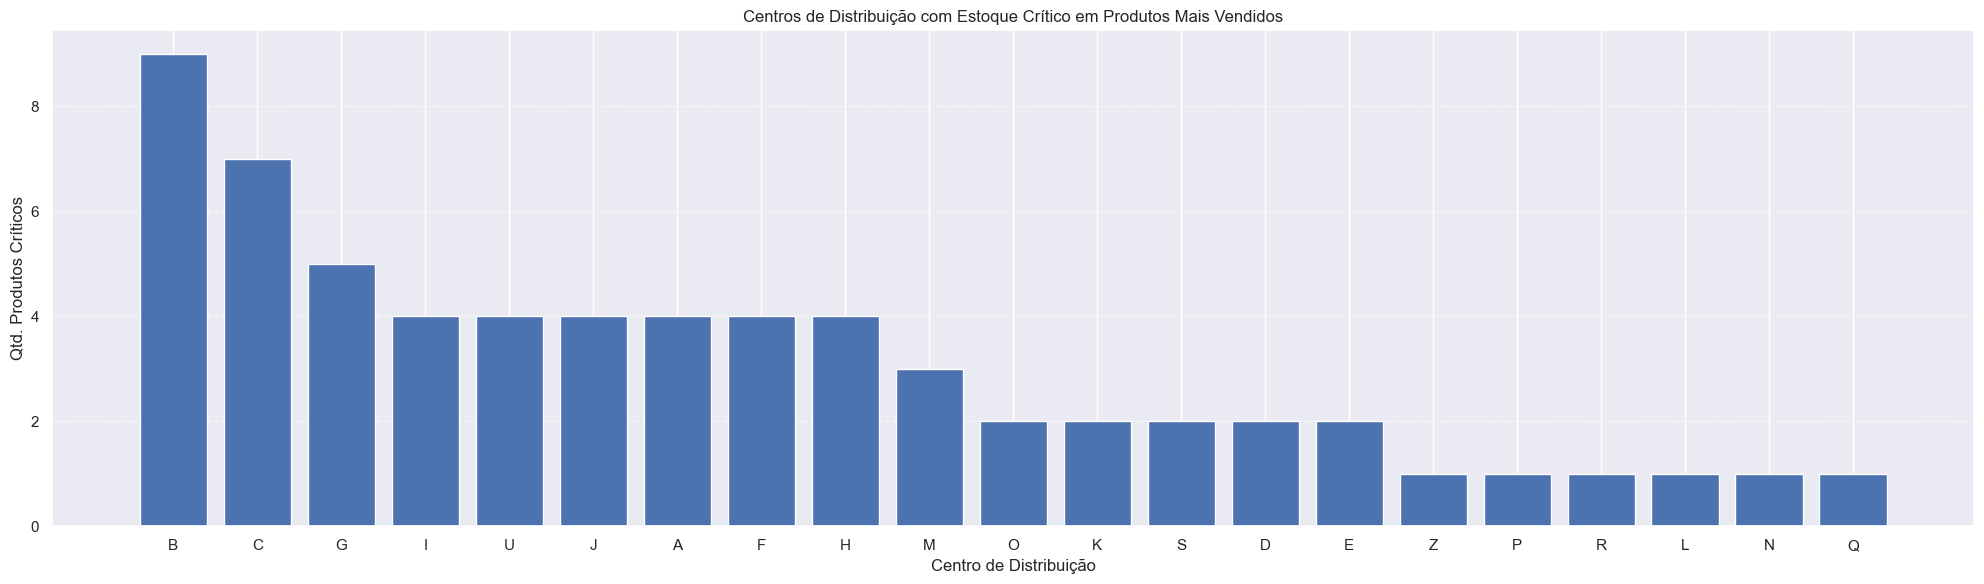

In [21]:
# Calcula total de vendas e estoque por PRODUTO + CENTRO
df_xgb['TOTAL_VENDAS'] = df_xgb[colunas_meses].sum(axis=1)

df_cd = df_xgb.groupby(['PRODUTO', 'CENTROS DE DISTRIBUICAO']).agg({
    'TOTAL_VENDAS': 'sum',
    'QTD DE CAIXAS': 'sum'  # pode usar 'mean' ou 'min' dependendo da lógica
}).reset_index()

# Identifica os produtos mais vendidos
limite_vendas = df_cd['TOTAL_VENDAS'].quantile(0.80)
produtos_mais_vendidos = df_cd[df_cd['TOTAL_VENDAS'] >= limite_vendas]

# Ordena pelos menores estoques
produtos_criticos = produtos_mais_vendidos.sort_values(by='QTD DE CAIXAS', ascending=True)

# Agrupa por CENTROS DE DISTRIBUICAO e soma o número de produtos críticos em cada um
cd_criticos = produtos_criticos.groupby('CENTROS DE DISTRIBUICAO').agg({
    'QTD DE CAIXAS': 'sum',
    'PRODUTO': 'count'  
}).rename(columns={'PRODUTO': 'QTDE_PRODUTOS_CRITICOS'}).reset_index()

# Ordena pelos mais críticos (menos estoque e mais produtos críticos)
cd_criticos = cd_criticos.sort_values(by=['QTDE_PRODUTOS_CRITICOS', 'QTD DE CAIXAS'], ascending=[False, True]).reset_index(drop=True)

display(cd_criticos.head()) 

# Grafico
plt.figure(figsize=(20,6))
plt.bar(cd_criticos['CENTROS DE DISTRIBUICAO'], cd_criticos['QTDE_PRODUTOS_CRITICOS'])
plt.title('Centros de Distribuição com Estoque Crítico em Produtos Mais Vendidos')
plt.xlabel('Centro de Distribuição')
plt.ylabel('Qtd. Produtos Críticos')
# plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# 3 - Análise de serie temporal

## 3.1. - Convertendo a base para série temporal

In [22]:
# Seleciona colunas de datas e identificadoras
colunas_meses = df_raw.columns[df_raw.columns.get_loc("MAR22"):]
colunas_identificadoras = df_raw.columns[:df_raw.columns.get_loc("MAR22")]

# Pivota o dataframe
df_temporal = df_raw.melt(
    id_vars=colunas_identificadoras, 
    value_vars=colunas_meses,
    var_name='DATA',
    value_name='VENDAS'
)

# Converte os meses de português para inglês
meses_pt_en = {
    'JAN': 'Jan', 'FEV': 'Feb', 'MAR': 'Mar', 'ABR': 'Apr', 'MAI': 'May', 'JUN': 'Jun',
    'JUL': 'Jul', 'AGO': 'Aug', 'SET': 'Sep', 'OUT': 'Oct', 'NOV': 'Nov', 'DEZ': 'Dec'
}

# Converte a coluna para o formato de data e coloca como índice
df_temporal['DATA'] = df_temporal['DATA'].replace(meses_pt_en, regex=True)
df_temporal['DATA'] = pd.to_datetime(df_temporal['DATA'], format='%b%y')
# df_temporal['DATA'] = df_temporal['DATA'].dt.to_period('M').astype(str)
df_temporal = df_temporal.sort_values('DATA').set_index('DATA')

# Unifica as colunas identificadoras em uma única coluna 'ID_PRODUTO'
df_temporal['ID_PRODUTO'] = df_temporal[colunas_identificadoras[:-1]].apply(lambda x: ''.join(x.astype(str)), axis=1)

# Exclui colunas que não são necessárias para a série temporal
df_temporal = df_temporal[['ID_PRODUTO', 'VENDAS']]

df_temporal.head(2)

,ID_PRODUTO,VENDAS
DATA,,
2022-03-01,AAAAAA,356
2022-03-01,ARMCKI,77


In [23]:
df_temporal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12500 entries, 2022-03-01 to 2024-03-01
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID_PRODUTO  12500 non-null  object
 1   VENDAS      12500 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 293.0+ KB


## 3.2. - Seleionando um produto (AAAAAA)

In [24]:
df_produto = df_temporal.loc[df_temporal.ID_PRODUTO == 'AAAAAA'].copy()
df_produto.index = pd.to_datetime(df_produto.index)
df_produto = df_produto.resample('M').sum()  

df_produto.head(2)

,ID_PRODUTO,VENDAS
DATA,,
2022-03-31,AAAAAA,356
2022-04-30,AAAAAA,374


## 3.3. - Decompondo a Série para visualizar tendência, sazonalidade e resíduos

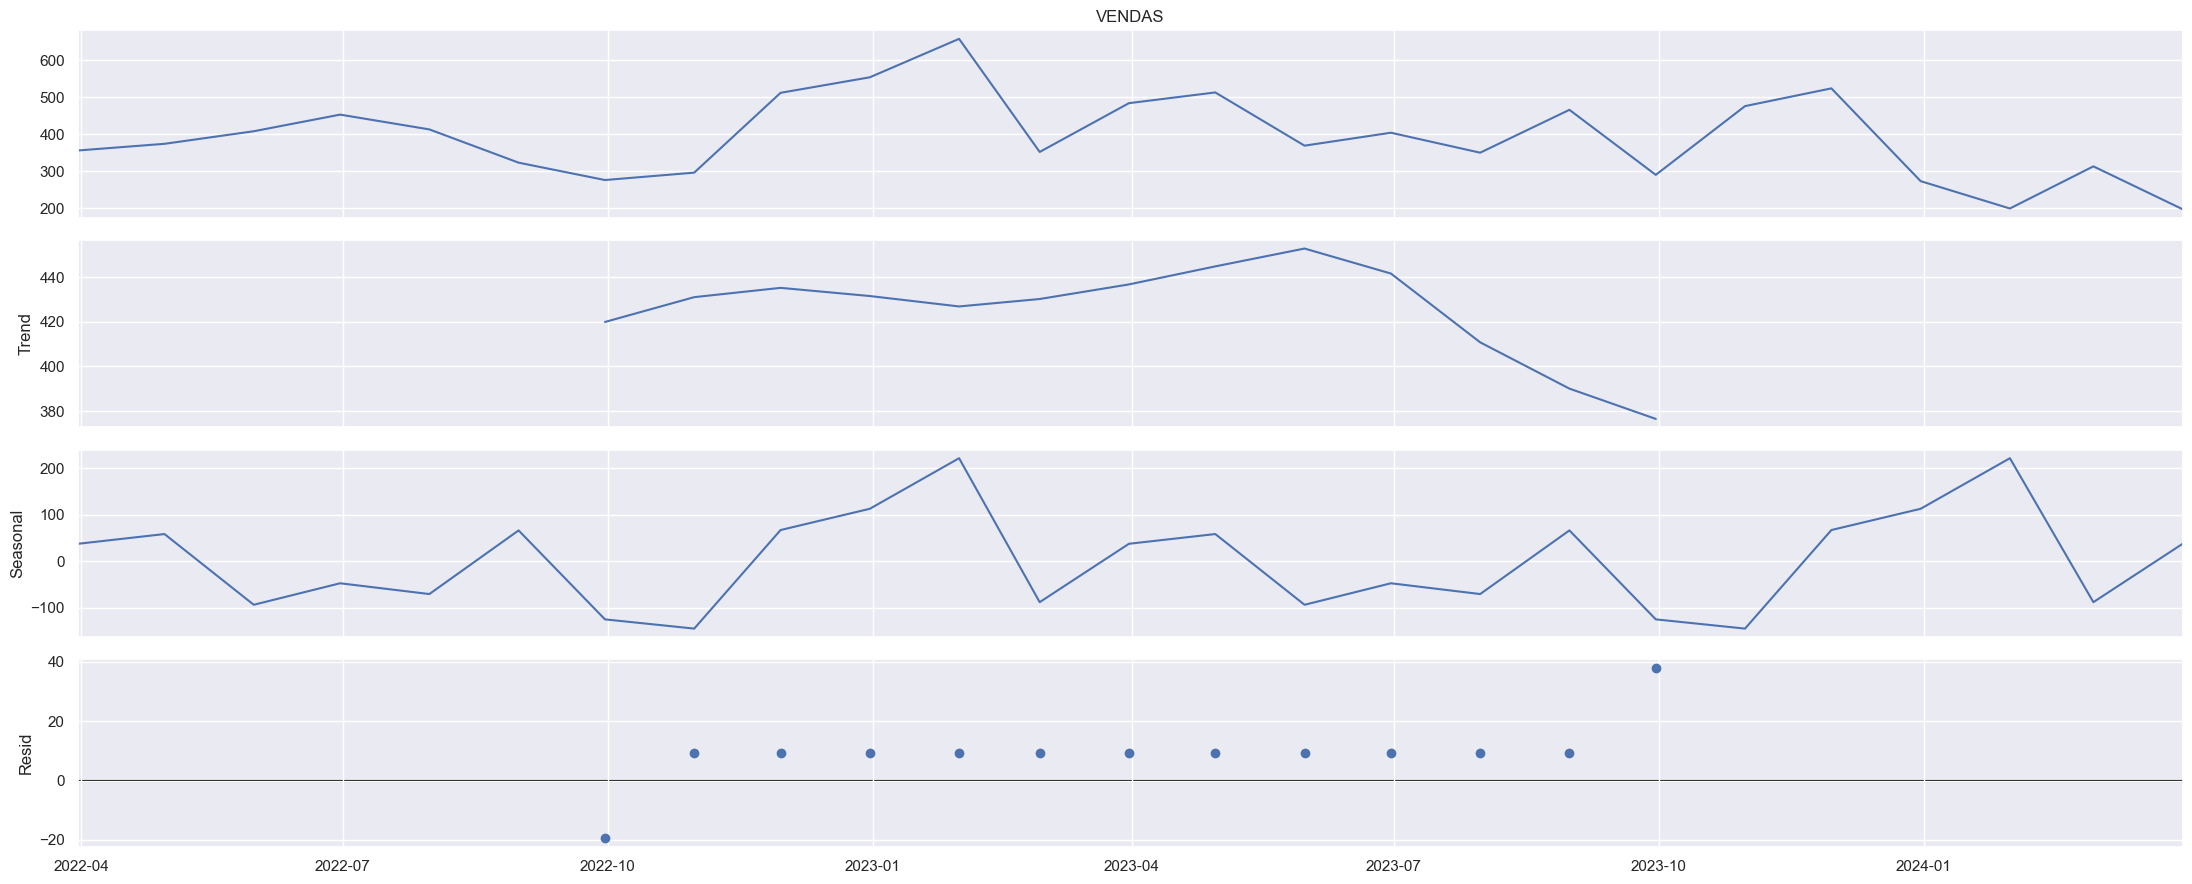

In [25]:
# Decomposição
decomposition = seasonal_decompose(df_produto['VENDAS'], model='additive', period=12)

# Gráfico
fig = decomposition.plot()
fig.set_size_inches(22, 9)
plt.show()

## 3.4. - Verificando estacionariedade da série com teste de Dickey Fuller

In [26]:
def verifica_estacionaridade(timeseries):
    """    Check if a time series is stationary using the Augmented Dickey-Fuller test. 
    Params:
        timeseries: pd.Series - The time series data to check for stationarity.
    Returns:
        bool - True if the time series is stationary, False otherwise.
    """
    result = adfuller(timeseries)
    print('Resultados do Teste Dickey–Fuller:')
    print('ADF - Estatísticas:', result[0])
    print('p-valor:', result[1])
    print('Valores críticos:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    return result[1] < 0.05

is_stationary = verifica_estacionaridade(df_produto['VENDAS'])
print(f"\nA Série Temporal é {'Estacionaria' if is_stationary else 'Não-Estacionaria'}")


Resultados do Teste Dickey–Fuller:
ADF - Estatísticas: -3.0166581512755024
p-valor: 0.033367752437210366
Valores críticos:
	1%: -3.7377092158564813
	5%: -2.9922162731481485
	10%: -2.635746736111111

A Série Temporal é Estacionaria


# 4 - Modelagem (Modelos Tradicionais)

## 4.1. Selecionando modelo e os melhores parâmetros

In [27]:
auto_model = auto_arima(df_produto['VENDAS'],
                        start_p=0, start_q=0,
                        max_p=5, max_q=5,
                        m=12,
                        seasonal=True,
                        d=None,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=310.979, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=310.422, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=309.213, Time=0.42 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=309.169, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=373.594, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=309.935, Time=0.06 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=311.168, Time=0.27 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=311.106, Time=0.37 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=309.107, Time=0.33 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=311.266, Time=0.48 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=313.106, Time=0.61 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=308.885, Time=0.25 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=311.106, Time=0.44 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=308.981, Time=0.18 sec
 ARIMA(0,0,0)(2,0,1)[12] intercep

## 4.2. Rodando o melhor modelo (ARIMA)

In [28]:
model = ARIMA(
    df_produto["VENDAS"],
    order=auto_model.order,
    seasonal_order=auto_model.seasonal_order,
)
results = model.fit()

In [29]:
forecat_periods = 12  
forecast = results.get_forecast(steps=forecat_periods)
mean_forecast = forecast.predicted_mean

## 4.3. Plotando as previsões do modelo

In [30]:
conf_int_95 = forecast.conf_int(alpha=0.05)  # Intervalo de confiança de 95%
conf_int_80 = forecast.conf_int(alpha=0.20)  # Intervalo de confiança de 80%
conf_int_70 = forecast.conf_int(alpha=0.30)  # Intervalo de confiança de 70%

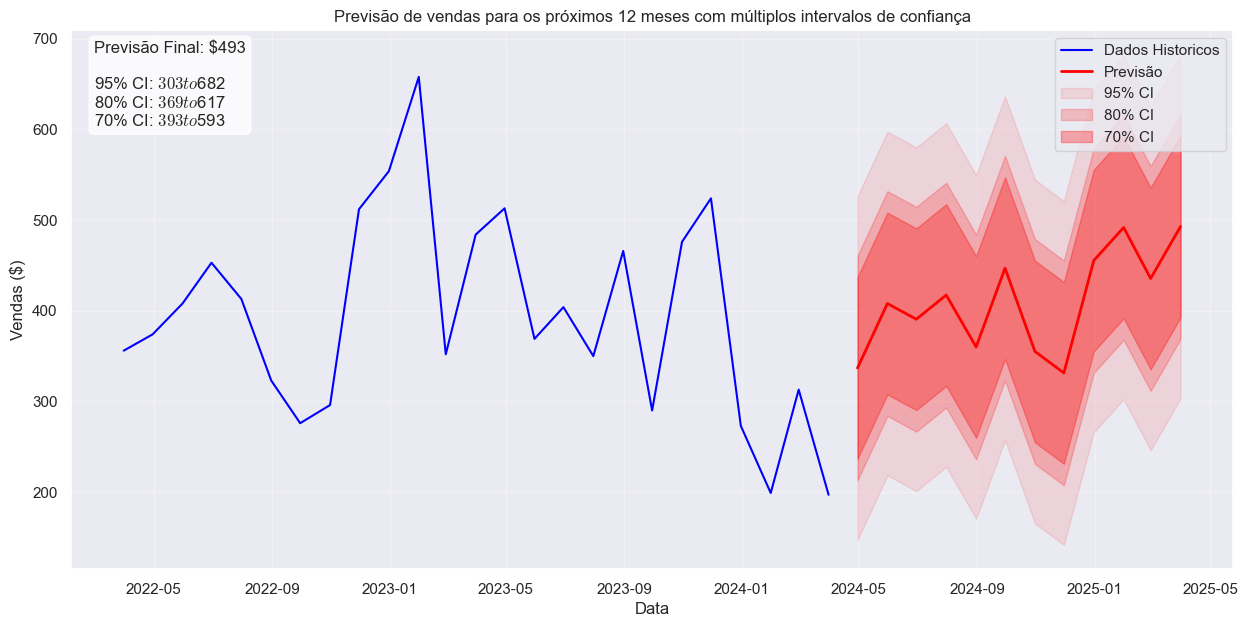

In [31]:
plt.figure(figsize=(15, 7))

# Plot historical data and forecast
plt.plot(df_produto["VENDAS"], label='Dados Historicos', color='blue')
plt.plot(mean_forecast, label='Previsão', color='red', linewidth=2)

# Plot confidence intervals
plt.fill_between(mean_forecast.index,
                 conf_int_95.iloc[:, 0],
                 conf_int_95.iloc[:, 1],
                 color='red', alpha=0.1,
                 label='95% CI')

plt.fill_between(mean_forecast.index,
                 conf_int_80.iloc[:, 0],
                 conf_int_80.iloc[:, 1],
                 color='red', alpha=0.2,
                 label='80% CI')

plt.fill_between(mean_forecast.index,
                 conf_int_70.iloc[:, 0],
                 conf_int_70.iloc[:, 1],
                 color='red', alpha=0.3,
                 label='70% CI')
plt.title('Previsão de vendas para os próximos 12 meses com múltiplos intervalos de confiança')
plt.xlabel('Data')
plt.ylabel('Vendas ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Get final values
last_forecast = mean_forecast.iloc[-1]
ranges_95_lower = conf_int_95.iloc[-1, 0]
ranges_95_upper = conf_int_95.iloc[-1, 1]
ranges_80_lower = conf_int_80.iloc[-1, 0]
ranges_80_upper = conf_int_80.iloc[-1, 1]
ranges_70_lower = conf_int_70.iloc[-1, 0]
ranges_70_upper = conf_int_70.iloc[-1, 1]

# Create info text
info_text = f'Previsão Final: ${last_forecast:,.0f}\n\n' \
            f'95% CI: ${ranges_95_lower:,.0f} to ${ranges_95_upper:,.0f}\n' \
            f'80% CI: ${ranges_80_lower:,.0f} to ${ranges_80_upper:,.0f}\n' \
            f'70% CI: ${ranges_70_lower:,.0f} to ${ranges_70_upper:,.0f}'

plt.text(0.02, 0.98, info_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()


## 4.4. Calculando e exibindo as métricas

In [32]:
# Calculando metricas
mae_arm = mean_absolute_error(df_produto["VENDAS"], results.fittedvalues)
mse_arm = mean_squared_error(df_produto["VENDAS"], results.fittedvalues)
rmse_arm = np.sqrt(mse_arm)
mape_arm = mean_absolute_percentage_error(df_produto["VENDAS"], results.fittedvalues)
wmape_arm = mean_absolute_percentage_error(df_produto["VENDAS"], results.fittedvalues, sample_weight=df_produto["VENDAS"]) * 100


# dataframe para comparar as métricas
df_metricas_arima = pd.DataFrame({
    'Modelo': ['ARIMA'],
    'MAE': [mae_arm],
    'MSE': [mse_arm],
    'RMSE': [rmse_arm],
    'MAPE': [mape_arm],
    'WMAPE': [wmape_arm]
})
df_metricas_arima


,Modelo,MAE,MSE,RMSE,MAPE,WMAPE
0,ARIMA,83.07,10765.60,103.76,0.23,21.12


In [33]:
# Dataframe de previsões
forecast_df = pd.DataFrame({
    'Forecast': mean_forecast,
    '95% Lower': conf_int_95.iloc[:, 0],
    '95% Upper': conf_int_95.iloc[:, 1],
    '80% Lower': conf_int_80.iloc[:, 0],
    '80% Upper': conf_int_80.iloc[:, 1],
    '70% Lower': conf_int_70.iloc[:, 0],
    '70% Upper': conf_int_70.iloc[:, 1]
})

print("Previsões detalhadas com intervalos de confiança:")
display(forecast_df)

Previsões detalhadas com intervalos de confiança:


,Forecast,95% Lower,95% Upper,80% Lower,80% Upper,70% Lower,70% Upper
2024-04-30,336.87,147.32,526.41,212.93,460.80,236.64,437.10
2024-05-31,407.96,218.42,597.50,284.02,531.89,307.73,508.19
2024-06-30,390.68,201.14,580.22,266.74,514.61,290.45,490.91
2024-07-31,417.34,227.80,606.88,293.40,541.27,317.11,517.57
2024-08-31,360.07,170.53,549.61,236.14,484.00,259.84,460.30
2024-09-30,446.96,257.42,636.50,323.03,570.90,346.73,547.19
2024-10-31,355.13,165.59,544.67,231.20,479.07,254.90,455.36
2024-11-30,331.44,141.89,520.98,207.50,455.37,231.21,431.67
2024-12-31,455.35,265.81,644.90,331.42,579.29,355.12,555.58
2025-01-31,491.89,302.35,681.43,367.95,615.82,391.66,592.12


# 5 - Modelagem (Modelos de Machine Learning)

## 5.1. Prophet

In [34]:
# Configurando o dataset para o Prophet
df_prophet = pd.DataFrame({
    'y': df_produto['VENDAS'],
    'ds': df_produto.index,
})

# Configurando o modelo Prophet
modelo_prophet = Prophet(
    growth='linear',    # Crescimento linear
    seasonality_mode='multiplicative',  # Modo de sazonalidade
    yearly_seasonality=True,  # Sazonalidade anual  
    weekly_seasonality=False,  # Sazonalidade semanal
    daily_seasonality=False,  # Sazonalidade diária
    interval_width=0.95,  # Intervalo de confiança de 95%
    changepoint_prior_scale=0.05,  # Regularização de pontos de mudança
    n_changepoints=10  # Número de pontos de mudança
)

# Treinando e fazendo as previsões
modelo_prophet.fit(df_prophet)
futuro = modelo_prophet.make_future_dataframe(periods=12, freq='M')
predicao_prophet = modelo_prophet.predict(futuro)
# predicao_prophet = predicao_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

20:56:03 - cmdstanpy - INFO - Chain [1] start processing
20:56:05 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
# Plotando as previsões do Prophet
from prophet.plot import plot_plotly, plot_components_plotly
fig = plot_plotly(modelo_prophet, predicao_prophet)
fig.update_layout(title='Previsões do Prophet para Vendas', xaxis_title='Data', yaxis_title='Vendas')
fig.update_layout(width=1480, height=600)
fig.show()


In [36]:
# Previsão para o intervalo histórico
futuro_treino = modelo_prophet.make_future_dataframe(periods=0, freq='M')  # só até hoje
previsao_treino = modelo_prophet.predict(futuro_treino)

# Mescla com os valores reais
df_merge = df_prophet.merge(previsao_treino[['ds', 'yhat']], on='ds')

# Cálculo das métricas
mae_pft = mean_absolute_error(df_merge['y'], df_merge['yhat'])
mse_pft = mean_squared_error(df_merge['y'], df_merge['yhat'])
rmse_pft = np.sqrt(mse_pft)
mape_pft = mean_absolute_percentage_error(df_merge['y'], df_merge['yhat']) * 100
wmape_pft = mean_absolute_percentage_error(df_merge['y'], df_merge['yhat'], sample_weight=df_merge['y']) * 100



# dataframe para comparar as métricas
df_metricas_prophet = pd.DataFrame({
    'Modelo': ['Prophet'],
    'MAE': [mae_pft],
    'MSE': [mse_pft],
    'RMSE': [rmse_pft],
    'MAPE': [mape_pft],
    'WMAPE': [wmape_pft]
})
# Exibe as métricas do Prophet
df_metricas_prophet

,Modelo,MAE,MSE,RMSE,MAPE,WMAPE
0,Prophet,38.38,2334.26,48.31,11.11,9.76


In [37]:
print("Previsões detalhadas do modelo:")
display(predicao_prophet.loc[predicao_prophet['ds'] >= '2024-04-30', ['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

Previsões detalhadas do modelo:


,ds,yhat,yhat_lower,yhat_upper
25,2024-04-30,-31.32,-131.76,65.19
26,2024-05-31,457.36,362.30,554.18
27,2024-06-30,664.44,570.91,753.40
28,2024-07-31,706.07,619.10,803.70
29,2024-08-31,244.88,157.01,341.55
30,2024-09-30,362.22,273.14,457.44
31,2024-10-31,-79.20,-173.22,16.26
32,2024-11-30,244.63,152.93,338.17
33,2024-12-31,645.01,552.51,739.23
34,2025-01-31,920.25,824.09,1015.22


## 5.2. XGBoost

In [38]:
# Dividindo o dataset entre treino e teste
df_treino = df_produto.loc[df_produto.index < '2023-07-31'].copy()
df_teste = df_produto.loc[df_produto.index >= '2023-07-31'].copy()

# Validadno os índices de treino e teste
print(f'Treino mínimo: {df_treino.index.min()} \nTreino máximo: {df_treino.index.max()}\n')
print(f'Teste mínimo: {df_teste.index.min()} \nTeste máximo: {df_teste.index.max()}')

Treino mínimo: 2022-03-31 00:00:00 
Treino máximo: 2023-06-30 00:00:00

Teste mínimo: 2023-07-31 00:00:00 
Teste máximo: 2024-03-31 00:00:00


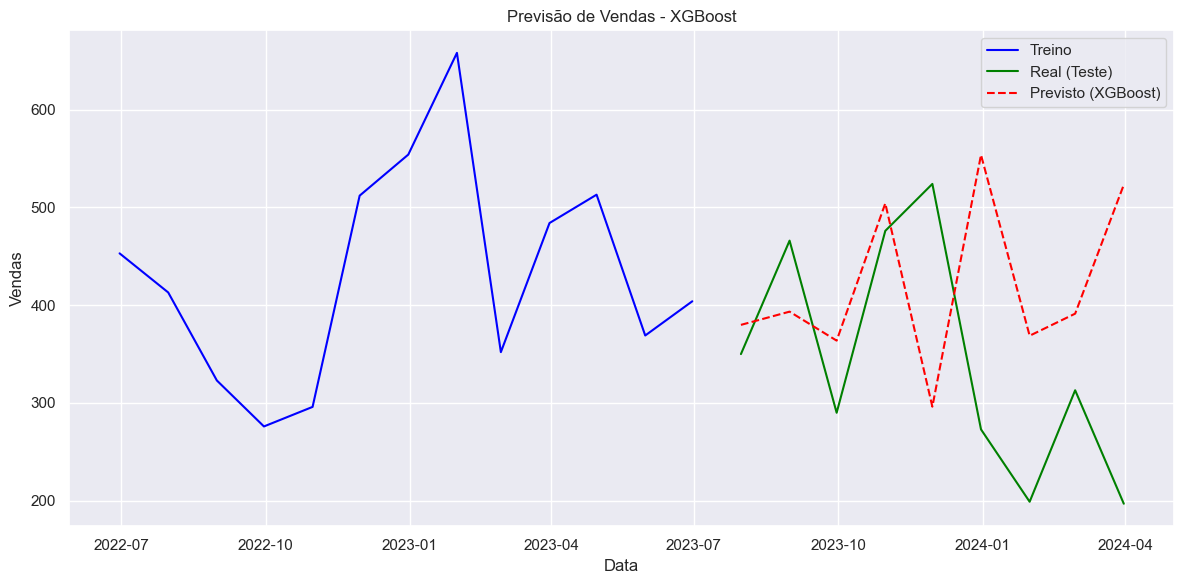

In [39]:
df_xgb = df_produto.copy()

# Garante que o índice seja datetime
df_xgb.index = pd.to_datetime(df_xgb.index)

# Cria variáveis de tempo
df_xgb['month'] = df_xgb.index.month
df_xgb['year'] = df_xgb.index.year

# Cria lags (últimos 1, 2 e 3 meses)
df_xgb['lag1'] = df_xgb['VENDAS'].shift(1)
df_xgb['lag2'] = df_xgb['VENDAS'].shift(2)
df_xgb['lag3'] = df_xgb['VENDAS'].shift(3)

# Remove os primeiros meses com NaN
df_xgb = df_xgb.dropna()

# Divide o dataset em treino e teste
df_treino = df_xgb.loc[df_xgb.index < '2023-07-31'].copy()
df_teste  = df_xgb.loc[df_xgb.index >= '2023-07-31'].copy()

# Features e target
features = ['month', 'year', 'lag1', 'lag2', 'lag3']
target = 'VENDAS'

X_train = df_treino[features]
y_train = df_treino[target]

X_test = df_teste[features]
y_test = df_teste[target]

# Treinamento e predição com XGBoost
modelo = XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

# Plot
plt.figure(figsize=(12,6))
plt.plot(df_treino.index, y_train, label='Treino', color='blue')
plt.plot(df_teste.index, y_test, label='Real (Teste)', color='green')
plt.plot(df_teste.index, y_pred, label='Previsto (XGBoost)', color='red', linestyle='--')
plt.title('Previsão de Vendas - XGBoost')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
# Calculando as métricas
mae_xgb = mean_absolute_error(y_test, y_pred)
mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred) * 100
wmape_xgb = mean_absolute_percentage_error(y_test, y_pred, sample_weight=y_test) * 100


# dataframe para comparar as métricas
df_metricas_xgb = pd.DataFrame({
    'Modelo': ['XGBoost'],
    'MAE': [mae_xgb],
    'MSE': [mse_xgb],
    'RMSE': [rmse_xgb],
    'MAPE': [mape_xgb],
    'WMAPE': [wmape_xgb]
})
# Exibe as métricas do XGBoost
df_metricas_xgb

,Modelo,MAE,MSE,RMSE,MAPE,WMAPE
0,XGBoost,143.00,31594.60,177.75,53.07,41.68


## 5.3. LSTM

1/1 [==============================] - 0s 327ms/step


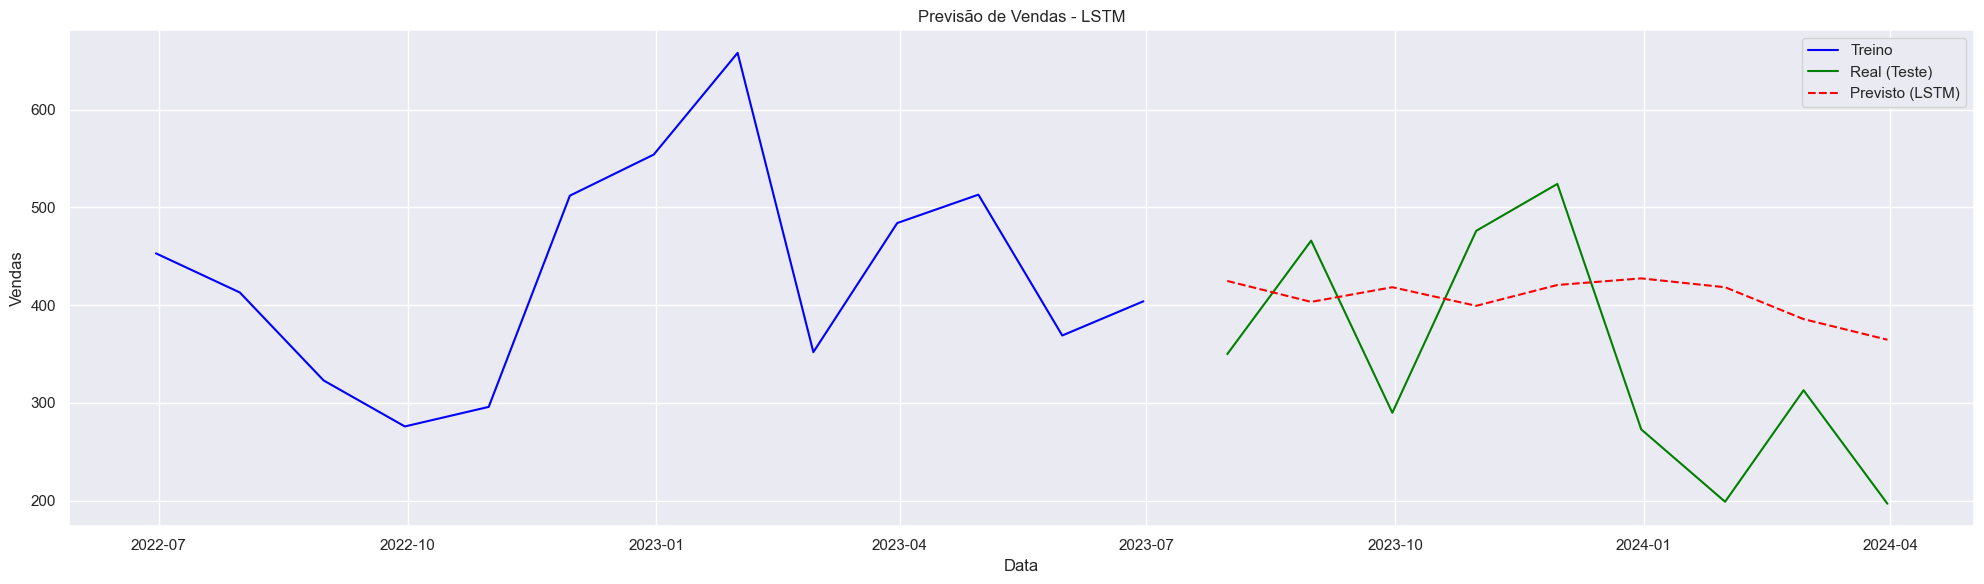

In [41]:
# Garante índice datetime
df = df_produto.copy()
df.index = pd.to_datetime(df.index)

# Normaliza os dados
scaler = MinMaxScaler()
df['VENDAS_NORM'] = scaler.fit_transform(df[['VENDAS']])

# Função para criar janelas temporais (lags para LSTM)
def criar_janelas(series, window=3):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

# Aplica a função
window_size = 3
X_all, y_all = criar_janelas(df['VENDAS_NORM'].values, window=window_size)

# Ajusta os índices para alinhar com o DataFrame original
datas = df.index[window_size:]

# Divide treino/teste com base na data
data_split = pd.Timestamp('2023-07-31')
idx_split = np.where(datas >= data_split)[0][0]

X_train, X_test = X_all[:idx_split], X_all[idx_split:]
y_train, y_test = y_all[:idx_split], y_all[idx_split:]
datas_train, datas_test = datas[:idx_split], datas[idx_split:]

# Reshape para LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))


# Criação, treinamento e previsão do modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=200, verbose=0)

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

# Plotando os resultados
plt.figure(figsize=(20,6))
plt.plot(datas_train, scaler.inverse_transform(y_train.reshape(-1,1)), label='Treino', color='blue')
plt.plot(datas_test, y_test_inv, label='Real (Teste)', color='green')
plt.plot(datas_test, y_pred_inv, label='Previsto (LSTM)', color='red', linestyle='--')
plt.title('Previsão de Vendas - LSTM')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
# dataframe para comparar as métricas
df_metricas_lstm = pd.DataFrame({
    'Modelo': ['LSTM'],
    'MAE': [mean_absolute_error(y_test_inv, y_pred_inv)],
    'MSE': [mean_squared_error(y_test_inv, y_pred_inv)],
    'RMSE': [np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))],
    'MAPE': [mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100],
    'WMAPE': [mean_absolute_percentage_error(y_test_inv, y_pred_inv, sample_weight=y_test_inv) * 100],
})
# Exibe as métricas do LSTM
df_metricas_lstm


,Modelo,MAE,MSE,RMSE,MAPE,WMAPE
0,LSTM,117.77,16434.09,128.20,43.34,34.32


# 6 - Comparando desempenho dos modelos

In [43]:
# Comparando as métricas dos modelos
df_metricas_comparacao = pd.concat([df_metricas_arima, df_metricas_prophet, df_metricas_xgb, df_metricas_lstm], ignore_index=True)
df_metricas_comparacao

,Modelo,MAE,MSE,RMSE,MAPE,WMAPE
0,ARIMA,83.07,10765.60,103.76,0.23,21.12
1,Prophet,38.38,2334.26,48.31,11.11,9.76
2,XGBoost,143.00,31594.60,177.75,53.07,41.68
3,LSTM,117.77,16434.09,128.20,43.34,34.32
